In [1]:
# Baseline Model

# Model - Logistic Reg,
# Features -
#     * All Channels - Raw, Abs, Mag (8)
#     * All Windows  - 1, 3, 5, 10, 15
#     * All Indiv    - Stat - Mean, Variance, Spec - PSD 6 bins
#     * All Pairwise -
#            - Synch - Correl, lag-Correl, MI, mimicry
#            - Convr - Sym.Conv, Asym.Conv, Glob.Conv
#     * All GroupFeat-
#            - Aggreagtion - Min, Max, Mean, Mode, Var
#            
# Evaluation - Acc, Conf.Matrix, AUC, Precision, Recall,

In [2]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [3]:
from modeling import dataset_provider as data_gen
from feature_extract import turntake_extractor as tt_extractor
import constants

from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, mean_squared_error, roc_auc_score, r2_score, explained_variance_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from imblearn import under_sampling 
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import numpy as np
import pandas as pd

Total Groups = 115


Using TensorFlow backend.


In [4]:
# Variables for baseline
random_seed=44
manifest="indiv"
data_split_per=.40
missing_data_thresh=50.0 #(in percent)
convq_thresh=3.0
agreeability_thresh=.2
annotators=["Divya", "Nakul"]#, "Swathi"]
only_involved_pairs=True
use_tt_features=False
splits = 5
if manifest=="group":
    smote_nn = 2
else:
    smote_nn = 6

tt_features = ["conv_eq", "#turns", "%talk", "mean_turn", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]

label_type = "hard"
model_type = "rand-for"
zero_mean  = False

dataset=constants.features_dataset_path_v5

In [18]:
# Functions 
def over_sample_data(temp_X, temp_y, method="SMOTE", k_neighbors=6):
    if method == "SMOTE":
        temp_X, temp_y = SMOTE(k_neighbors=k_neighbors-1, random_state=random_seed).fit_resample(temp_X, temp_y)
    return temp_X, temp_y

def feature_normalize(temp_X, method="min-max"):
    # Fit on training set only.
    if method == "min-max":
        normaliser = MinMaxScaler().fit(temp_X)
    elif method == "mean-var":
        normaliser = StandardScaler().fit(temp_X)
    return normaliser
    
def feature_selection(temp_X, temp_y, method="anova"):
    top_features = []
    if method == "anova":
        f_values, p_values = f_classif(temp_X, temp_y)
        top_features=np.where(np.array(p_values) <= 0.1)[0]
#         print(top_features)
        print("# Top Features = " + str(len(top_features)))
    return top_features

def select_required_features(temp_X, required_feats):
    temp_X=temp_X[:,required_feats]
#     print("After Feature Selection, Features -> " + str(temp_X.shape))
    return temp_X

def dimension_reduction(temp_X, method="pca"):
    dim_red_model = None
    if method=="pca":
        dim_red_model = PCA(.95).fit(temp_X)
    elif method=="tsne":
        dim_red_model = TSNE(n_components=2).fit(temp_X)
    return dim_red_model
    
def process_convq_labels(y, label_type="soft"):
    print("Data-type of labels - " + str(type(y)))
    if label_type=="soft":
        y=list(np.around(np.array(y),2))
    else:
        y=list(np.where(np.array(y) <= convq_thresh, 0, 1))
        print("ConvQ Classes Distribution : (Total = "+ str(len(y)) +")")
        print("High Quality Conv = " + str(sum(y)))
        print("Low Quality Conv = " + str(len(y)-sum(y)))
    return y

def model_convq_manifestation(temp_X, temp_y, model="log-reg"):

    if model == "log-reg":
        model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced').fit(temp_X, temp_y)
    elif model == "lin-reg":
        model = LinearRegression().fit(temp_X, temp_y)
    elif model == "adaboost":
        model = AdaBoostClassifier(n_estimators=500).fit(temp_X, temp_y)
    elif model == "dec-tree":
        model = DecisionTreeClassifier(class_weight='balanced').fit(temp_X, temp_y)
    elif model == "rand-for":
        model = RandomForestClassifier(n_estimators=1000, class_weight='balanced').fit(temp_X, temp_y)
    elif model == "svm":
        model = SVC(kernel='poly').fit(temp_X, temp_y)
    elif model == "log-elastic":
        model = SGDClassifier(loss="log", max_iter=10000, class_weight='balanced').fit(temp_X, temp_y)
    elif model == "grad-boost-quant":
        model = GradientBoostingRegressor(loss='quantile',n_estimators=1000).fit(temp_X, temp_y)
    return model

def get_model_predict_proba(temp_X, model):
    return model.predict_proba(temp_X)[::,1]

def analyse_model_params(model):
    return True

def test_model(temp_X, model):
    return model.predict(temp_X)

def evaluate_predict(test_temp_y, predict_temp_y, method=accuracy_score):
    score = method(test_temp_y, predict_temp_y)
    return score

In [6]:
# Data Read
X, y, ids = data_gen.get_dataset_for_experiment(dataset=dataset,
                                                    manifest=manifest,
                                                    missing_data_thresh=missing_data_thresh,
                                                    agreeability_thresh=agreeability_thresh,
                                                    annotators=annotators,
                                                    only_involved_pairs=only_involved_pairs,
                                                    zero_mean=zero_mean)

# print(y)

Generating Dataset for modeling - indiv ConvQ, ...........
Number of Groups (After removing missing data) - 85
ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False


22it [00:00, 215.56it/s]

Number of Final Data-points (After removing unreliable annotation data) - 179


179it [00:00, 206.65it/s]


In [7]:
# Get Turn-Taking feaures for IDs (group/ indiv)
if use_tt_features:
    tt_X = tt_extractor.get_tt_dataset_feats_for(ids, tt_features, manifest)
    final_X = np.concatenate((X, tt_X), axis=1)
else:
    final_X = X    
print("Final Feature Set - " + str(final_X.shape))

Final Feature Set - (179, 714)


In [8]:
# final_X = tt_X #np.concatenate((X, tt_X), axis=1)

In [9]:
# Label Prep
# Hard/Soft Labels
y = process_convq_labels(y, label_type)

Data-type of labels - <class 'list'>
ConvQ Classes Distribution : (Total = 179)
High Quality Conv = 163
Low Quality Conv = 16


In [23]:
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=data_split_per, random_state=random_seed)
final_conf_matrix = [[0,0],[0,0]]
final_auc_score = 0.0
final_r_squared = 0.0
final_expl_vari = 0.0
iterative_auc = 0.0
final_predict = []
final_pred_prob = []
final_label = []

skf = StratifiedKFold(n_splits=splits)
for train_index, test_index in skf.split(final_X, y):

    # Data Prep
    train_X, test_X  = final_X[train_index], final_X[test_index]
    train_y, test_y  = [y[i] for i in train_index], [y[i] for i in test_index]
        
    # Transform Features
    normaliser = feature_normalize(train_X, method="mean-var")
    # Apply transform to both the training set and the test set.
    train_X = normaliser.transform(train_X)
    test_X  = normaliser.transform(test_X)
    
    # Dimensionality Reduction
#     dimension_model = dimension_reduction(train_X, method="pca")
#     train_X = dimension_model.transform(train_X)
#     test_X  = dimension_model.transform(test_X)
    
    # Feature Selection
    top_features = feature_selection(train_X, train_y, method="anova")
    train_X = select_required_features(train_X, top_features) 
    test_X  = select_required_features(test_X, top_features) 

    # SAMPLING
    train_X, train_y = over_sample_data(train_X, train_y, method="SMOTE", k_neighbors=smote_nn)
    
    print("Train Data -> Features - " + str(train_X.shape) + " and Labels - " + str(len(train_y)))
    print("Test  Data -> Features - " + str(test_X.shape) + " and Labels - " + str(len(test_y)))
    print(str(sum(train_y))) 
    
    # Modelling
    model         = model_convq_manifestation(train_X, train_y, model_type)
    #Predict
    predict_y     = test_model(test_X, model) 
    predict_proba = get_model_predict_proba(test_X, model)
    
    iterative_auc = iterative_auc + evaluate_predict(test_y, predict_y, roc_auc_score)
    
    final_predict.extend(predict_y)
    final_pred_prob.extend(predict_proba)
    final_label.extend(test_y)

# Top Features = 60
Train Data -> Features - (260, 60) and Labels - 260
Test  Data -> Features - (36, 60) and Labels - 36
130
# Top Features = 58
Train Data -> Features - (260, 58) and Labels - 260
Test  Data -> Features - (36, 58) and Labels - 36
130
# Top Features = 83
Train Data -> Features - (260, 83) and Labels - 260
Test  Data -> Features - (36, 83) and Labels - 36
130
# Top Features = 69
Train Data -> Features - (262, 69) and Labels - 262
Test  Data -> Features - (36, 69) and Labels - 36
131
# Top Features = 71
Train Data -> Features - (262, 71) and Labels - 262
Test  Data -> Features - (35, 71) and Labels - 35
131


In [24]:
final_conf_matrix = evaluate_predict(final_label, final_predict, confusion_matrix)
final_auc_score   = evaluate_predict(final_label, final_predict, roc_auc_score)

In [25]:
print("~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~")
print(final_conf_matrix)
print("~~~~~~~~~~~ AUC Score ~~~~~~~~~~~")
print(final_auc_score)
print("~~~~~~~~~~~ Iterative AUC ~~~~~~~~~~~~")
print(iterative_auc/skf.get_n_splits(final_X, y))

~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[  4  12]
 [ 18 145]]
~~~~~~~~~~~ AUC Score ~~~~~~~~~~~
0.5697852760736196
~~~~~~~~~~~ Iterative AUC ~~~~~~~~~~~~
0.5609848484848485


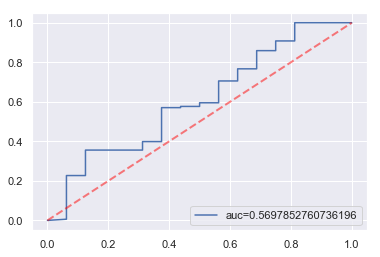

In [26]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(final_label, final_pred_prob)
plt.plot(fpr,tpr,label="auc="+str(final_auc_score), color='b')
plt.plot([0, 1], [0, 1], color='red', alpha=0.5, lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()